# GAN Training

## imports

In [1]:
import os
import matplotlib.pyplot as plt
# import cv2
import numpy as np
from models.GAN import GAN
from utils.loaders import load_safari

from PIL import Image, ImageOps
from numpy import asarray


## Dataset construction 

In [2]:
directory = 'data/dataset'
directory_r = 'data/dataset_rework/'
definition_px = 128
count = 0
for filename in os.listdir(directory):
    count+=1
    
dataset = np.zeros([count*3,definition_px*definition_px])
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    # load the image
    im = np.array(Image.open(f).convert('L'))
    
    # Resize image and convert in greycolor
    load_img_rz = np.array(Image.fromarray(im).resize((definition_px,definition_px)))
    # Save the image in jpeg
    Image.fromarray(load_img_rz).save(directory_r + 'r_'+filename)
    # create Pillow image
    true_img = Image.fromarray(load_img_rz)
    #Flip image
    im_flip = ImageOps.flip(true_img)
    im_flip.save(directory_r + 'f_'+filename)
    load_img_flip = np.array(im_flip)
    #Mirror image
    im_mirror = ImageOps.mirror(true_img)
    im_mirror.save(directory_r + 'm_'+filename)
    load_img_mirror = np.array(im_mirror)
    
    
    rz = np.zeros([1,load_img_rz.size])
    flip = np.zeros([1,load_img_flip.size])
    mirror = np.zeros([1,load_img_mirror.size])
    k = 0
    for i in range(definition_px):
        for j in range(definition_px):
            rz[0,k] = load_img_rz[i,j]
            flip[0,k] = load_img_flip[i,j]
            mirror[0,k] = load_img_mirror[i,j]
            k+=1
            
    dataset[count,:] = rz[0,:]
    count +=1        
    dataset[count,:] = flip[0,:]
    count +=1   
    dataset[count,:] = mirror[0,:]
    count +=1   

np.save('./data/dataset_rework.npy', dataset)

In [3]:
# run params
SECTION = 'gan'
RUN_ID = '0010'
DATA_NAME = 'drawing'
RUN_FOLDER = 'D:/PTUT/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'load' #'build' #


## data

In [4]:
(x_train, y_train) = load_safari('dataset_py_rework')

In [5]:
x_train.shape

(384, 128, 128, 1)

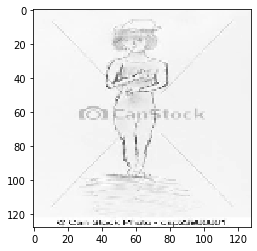

In [6]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

## architecture

In [7]:
gan = GAN(input_dim = (128,128,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (32, 32, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [8]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 128, 128, 1)]     0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 64, 64, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 32, 32, 64)        102464    
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0     

In [9]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
activation_4 (Activation)    (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 64, 64, 128)       2049

## training

In [10]:
BATCH_SIZE = 50
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 50

In [11]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 [D loss: (8.602)(R 0.418, F 16.785)] [D acc: (0.360)(0.720, 0.000)] [G loss: 0.710] [G acc: 0.420]
1 [D loss: (0.582)(R 0.491, F 0.673)] [D acc: (0.680)(0.660, 0.700)] [G loss: 0.739] [G acc: 0.320]
2 [D loss: (0.746)(R 0.397, F 1.095)] [D acc: (0.460)(0.840, 0.080)] [G loss: 0.726] [G acc: 0.160]
3 [D loss: (0.600)(R 0.477, F 0.723)] [D acc: (0.610)(0.740, 0.480)] [G loss: 0.697] [G acc: 0.400]
4 [D loss: (0.620)(R 0.429, F 0.811)] [D acc: (0.480)(0.700, 0.260)] [G loss: 0.752] [G acc: 0.020]
5 [D loss: (0.599)(R 0.517, F 0.681)] [D acc: (0.620)(0.540, 0.700)] [G loss: 0.751] [G acc: 0.020]
6 [D loss: (0.564)(R 0.455, F 0.673)] [D acc: (0.700)(0.620, 0.780)] [G loss: 0.746] [G acc: 0.060]
7 [D loss: (0.590)(R 0.478, F 0.702)] [D acc: (0.610)(0.640, 0.580)] [G loss: 0.760] [G acc: 0.020]
8 [D loss: (0.588)(R 0.524, F 0.651)] [D acc: (0.730)(0.620, 0.840)] [G loss: 0.768] [G acc: 0.000]
9 [D loss: (0.565)(R 0.499, F 0.630)] [D acc: (0.780)(0.600, 0.960)] [G loss: 0.782] [G acc: 0.020]

KeyboardInterrupt: 

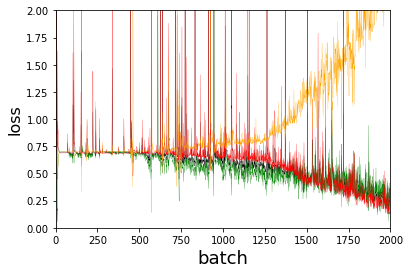

In [116]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()


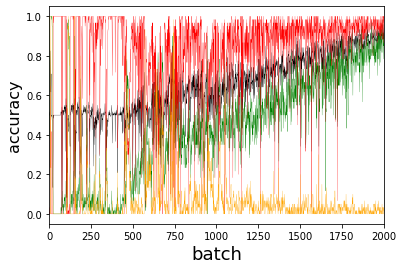

In [117]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()